### **Definir el directorio de trabajo con Google Colab**
Define el directorio de trabajo como la carpeta `data` de la carpeta compartida `DS4A-Team12` de Drive.

In [ ]:
import os
from google.colab import drive 
# Enlazar a la carpeta data de la carpeta compartida en Drive
drive.mount('/content/drive')
working_dir = '/content/drive/MyDrive/DS4A-Team12/data'
os.chdir(working_dir)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/DS4A-Team12/data


In [ ]:
# Librerias relevantes 
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
from scipy.interpolate import interp1d
#import tensorflow as tf

import statsmodels.api         as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smm
import os
from scipy import stats, special
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
 
%matplotlib inline
plt.style.use('ggplot')
 
# Opciones de visualización
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def age_estimated(height):
  if height < 65:
    age = max((6/15) * (height - 50), 0)
  else:
    age = min((54/45) * (height - 65) + 6, 59)
  return age
# Las curvas que necesitamos están acotadas entre las rectas (altura, peso):
# Por arriba, la recta entre los puntos (45, 4) y (110, 26)
# w = (22/65) * (h - 45) + 4 
# Por abajo, la recta entre los puntos (45, 1) y (110, 13)
# w = (12/65) * (h - 45) + 1
data = pd.DataFrame(columns=['age', 'height', 'weight', 'sex'])
heights = np.linspace(45, 121, 100)
for sex in ['F', 'M']:
  for h in heights:
    max_weight = (28/75) * (h - 45) + 4
    min_weight = (14/75) * (h - 45) + 1
    weights = np.linspace(min_weight, max_weight, 100)
    #age_approx = age_estimated(h) #np.nan #max((24/40) * (h - 50), 0)
    for w in weights:
      data = data.append(pd.DataFrame({'age': [age_estimated(h)],
                                       'height': [h],
                                       'weight': [w],
                                       'sex': [sex]}))
data = data.reset_index(drop=True)
data

,age,height,weight,sex
0,0,45.0,1.000000,F
1,0,45.0,1.030303,F
2,0,45.0,1.060606,F
3,0,45.0,1.090909,F
4,0,45.0,1.121212,F
...,...,...,...,...
19995,59,121.0,31.678923,M
19996,59,121.0,31.852525,M
19997,59,121.0,32.026128,M
19998,59,121.0,32.199731,M


In [ ]:
data[data.sex=='M']

,age,height,weight,sex
10000,0,45.0,1.000000,M
10001,0,45.0,1.030303,M
10002,0,45.0,1.060606,M
10003,0,45.0,1.090909,M
10004,0,45.0,1.121212,M
...,...,...,...,...
19995,59,121.0,31.678923,M
19996,59,121.0,31.852525,M
19997,59,121.0,32.026128,M
19998,59,121.0,32.199731,M


In [ ]:
data.to_csv('auxiliary_data/region_peso_talla.csv')

Este archivo se procesa mediante el software `Anthro Survey Analyser` disponible en línea en https://worldhealthorg.shinyapps.io/anthro/.

In [ ]:
df.shape

(12272, 4)

In [ ]:
data_to_fit = pd.read_csv('auxiliary_data/region_peso_talla_zscore.csv')

In [ ]:
included = (data_to_fit['zwfl'] > -3.2) & (data_to_fit['zwfl'] < 3.2)
df = data_to_fit[included][['height', 'weight', 'sex', 'zwfl']]
unique_heights = df['height'].sort_values().unique()
len(unique_heights)

98

In [ ]:
zscores = [i - 3 for i in range(7)]
weights_sex_zscore = dict()
for sex in ['F', 'M']:
  for z in zscores:
    weights_sex_zscore[(sex, z)] = list()
  for h in df['height'].unique():  
    weights_z = list()
    x = list(df[(df['height'] == h) & (df['sex'] == sex)]['zwfl'])
    y = list(df[(df['height'] == h) & (df['sex'] == sex)]['weight'])
    interpoler = interp1d(x, y)
    for z in zscores:
      w_z = float(interpoler(z))
      weights_sex_zscore[(sex, z)].append(w_z)

In [ ]:
points = pd.DataFrame({'height': unique_heights})
for sex in ['F', 'M']:
  for z in zscores:
    weights_z = pd.DataFrame({f'weight_{sex}_{z}': weights_sex_zscore[(sex, z)]})
    points = pd.concat([points, weights_z], axis=1)
points

,height,weight_F_-3,weight_F_-2,weight_F_-1,weight_F_0,weight_F_1,weight_F_2,weight_F_3,weight_M_-3,weight_M_-2,weight_M_-1,weight_M_0,weight_M_1,weight_M_2,weight_M_3
0,45.000000,1.901116,2.065954,2.251894,2.461039,2.696970,2.966942,3.275758,1.877104,2.042781,2.230303,2.441558,2.679293,2.951515,3.260606
1,45.767677,2.002234,2.176125,2.370986,2.591611,2.841952,3.124531,3.450503,1.977168,2.151845,2.347834,2.569630,2.818139,3.103172,3.426161
2,46.535354,2.102571,2.284491,2.490579,2.721773,2.982714,3.281798,3.623737,2.078109,2.261057,2.466234,2.697513,2.957564,3.255239,3.592014
3,47.303030,2.203039,2.394197,2.610154,2.853027,3.127526,3.442484,3.799647,2.181158,2.371440,2.587057,2.826377,3.098655,3.408154,3.758843
4,48.070707,2.306455,2.507368,2.732984,2.986375,3.275581,3.601621,3.979393,2.287036,2.486137,2.708922,2.960198,3.245504,3.565528,3.931269
5,48.838384,2.413081,2.624092,2.860229,3.125707,3.427714,3.770981,4.164966,2.398153,2.606426,2.838017,3.100130,3.396431,3.730028,4.110741
6,49.606061,2.526696,2.747345,2.993231,3.272358,3.589441,3.949547,4.362818,2.516094,2.733585,2.974851,3.248366,3.555770,3.904888,4.300438
7,50.373737,2.647684,2.877512,3.135287,3.428443,3.760197,4.138083,4.568495,2.639422,2.866511,3.119113,3.405893,3.724969,4.089561,4.501102
8,51.141414,2.774639,3.016081,3.288402,3.596187,3.943550,4.338264,4.793390,2.769986,3.006227,3.271649,3.567421,3.901985,4.282420,4.710555
9,51.909091,2.908357,3.161719,3.447234,3.769592,4.134844,4.551537,5.029133,2.908357,3.156302,3.430727,3.741261,4.089873,4.483784,4.932844


In [ ]:
points.to_csv('auxiliary_data/puntos_peso_talla.csv')

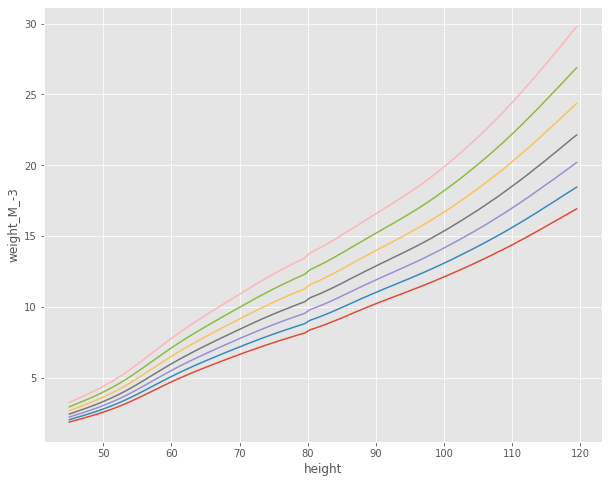

In [ ]:
points = pd.read_csv('auxiliary_data/puntos_peso_talla.csv')
fig, ax = plt.subplots(figsize=(10, 8))
sex = 'M'
for z in zscores:
  sns.lineplot(data=points, x='height', y=f'weight_{sex}_{z}', ax=ax)
fig.show()